In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#Road to DTW - Going the Distance

We'll use the best thing we got from the last section, which is cost matrix purely in numpy

In [2]:
import numpy as np

In [18]:
%%time
X = np.sin(np.linspace(0,10,1000))
Y = np.cos(np.linspace(0,10,500))
XX, YY = np.meshgrid(X, Y)
cost_matrix = np.abs(XX-YY)

CPU times: user 5.11 ms, sys: 898 µs, total: 6.01 ms
Wall time: 4.94 ms


The idea is to find the lowest cumulative cost for each cell. Starting at the origin and going to the last cell (i, j), DTW normally tries to find the path that will give the lowest sum of individual cell. But for my case I'm only interested in getting the warping distance between the two arrays, so we'll go with a naive approach of iterating through all the cells, bottom up and left right.

For the distance matrix I am padding the first column and first row with infinite value just to make it easier when calculating the cumulative cost. D[0,0] = 0 because we want the bottom left cell to add zero and not infinity.

In [4]:
_x, _y = cost_matrix.shape
D = np.empty((_x+1, _y+1))
D[:,0] = np.inf
D[0,:] = np.inf
D[0,0] = 0

In [5]:
%%time
x_len, y_len = cost_matrix.shape
for x in range(0, x_len):
    d_x = x + 1
    for y in range(0, y_len):
        d_y = y + 1
      
        left = D[d_x-1, d_y]
        bottom = D[d_x, d_y-1]
        diag = D[d_x-1, d_y-1]
        
        D[d_x, d_y] = np.min([left, bottom, diag]) + cost_matrix[x, y]

CPU times: user 3.73 s, sys: 24.2 ms, total: 3.76 s
Wall time: 3.74 s


Here's look at what the distance matrix looks like. Each cell is the lowest cummulative cost from the bottom left.

In [196]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl

In [197]:
mpl.rcParams['figure.figsize'] = [10,5]

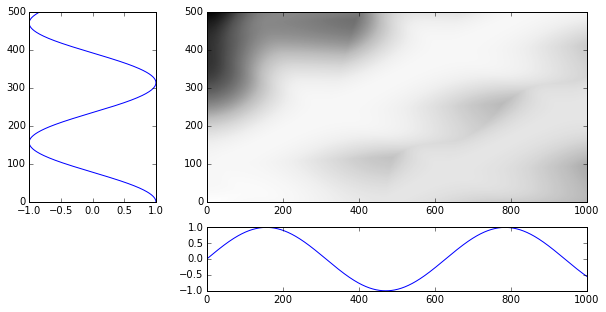

In [198]:
gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,1])
ax = plt.subplot(gs[0,1])
axl = plt.subplot(gs[0,0], sharey=ax)
axb = plt.subplot(gs[1,1], sharex=ax)

ax.imshow(D[1:,1:].T, origin='lower', extent=(0,1000,0,500), aspect='auto', cmap='Greys')

axl.plot(Y, range(500))
axb.plot(range(1000), X)

# plt.imshow(np.flipud(D), origin='lower', cmap='gray')

---

I said that this is a naive approach, but really that's the only way. We cannot vectorize or parallelize because every cell depends on the result of the previous one. There is no way around that. We will later look at dynamic programming, but that still is not possible to vectorize or parallelize anything.

Considering that our only interest is the warping distance, the main problem with this iterative method is memory. We are keeping a cost matrix around when we could quite simple calculate it as we iterate. Also, we are filling the distance matrix even though it's unecessary. We only need to keep the current column and the previous one for the calculation of the warping distance.

The cost matrix is really easy to compute and is pretty fast thanks to numpy. But let's calculate it along the way.

In [14]:
X = [1,1,2,2,3,3]
Y = [1,2,3,4,5]

In [23]:
%%time
previous_column = np.empty(len(Y)+1)
previous_column[:] = np.inf
previous_column[0] = 0

for x in range(0, len(X)):
    current_column = np.empty(len(Y)+1)
    current_column[0] = np.inf
    
    for y in range(0, len(Y)):
        cost = np.abs(X[x] - Y[y])
      
        left = previous_column[y+1]
        bottom = current_column[y]
        diag = previous_column[y]
        
        current_column[y+1] = np.min([left, bottom, diag]) + cost
    previous_column = current_column.copy()

CPU times: user 4.17 s, sys: 48.7 ms, total: 4.22 s
Wall time: 4.19 s


In [21]:
current_column[-1]

81.556435997289213

In [22]:
D[-1,-1]

81.556435997289213

In [87]:
from mlpy import dtw

In [169]:
dist, cost, path = dtw.dtw_std(X, Y, dist_only=False)

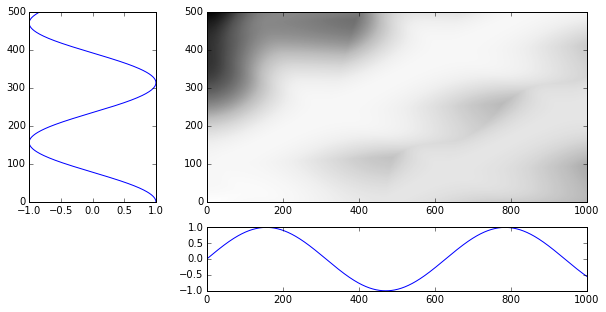

In [136]:
gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,1])
ax = plt.subplot(gs[0,1])
axl = plt.subplot(gs[0,0], sharey=ax)
axb = plt.subplot(gs[1,1], sharex=ax)

ax.imshow(cost, origin='lower', extent=(0,1000,0,500), aspect='auto', cmap='Greys')

axl.plot(Y, range(500))
axb.plot(range(1000), X)

In [170]:
cost

array([[   1.        ,    1.9997992 ,    2.9989961 , ...,  325.77522942,
         326.62503396,  327.46410549],
       [   1.98999016,    1.98978936,    2.97897642, ...,  325.27473728,
         326.13455166,  326.98363303],
       [   2.96997147,    2.96956988,    2.96896758, ...,  324.78772295,
         325.65754618,  326.51663639],
       ..., 
       [ 813.4706829 ,  813.2726237 ,  812.68772222, ...,   82.25537934,
          82.5780689 ,   82.89002544],
       [ 815.00627779,  814.80801778,  814.222514  , ...,   81.60242737,
          81.91663703,   82.22011368],
       [ 816.5502989 ,  816.3518381 ,  815.76573201, ...,   80.95560215,
          81.26138558,   81.556436  ]])

In [175]:
D[1:,1:].T.shape

(1000, 500)

In [176]:
cost_matrix.shape

(500, 1000)

In [177]:
dist

81.55643599728921